In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/tf/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator

warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()

def create_dataframe_from_query(query,column_list):
    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=column_list
    )

    return indicators_raw_df

In [2]:
########################
# Create BTC_USDT featrue dataframe
########################
query = f"""
    with 
    ohlcv_minute_data as
    (
        select 
            open,
            high,
            low,
            close,
            amount as total_volume,
            quantity as total_quantity,
            tradeCount as total_trade_count,
            date_trunc('minute',ts_create_utc) as ts
        from 
            hive.crypto_raw.candles_minute 
        where 
            id = 'BTC_USDT'
    ),
    buy_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as buy_trade_count,
            sum(amount) as sum_buy_taker_amount,
            sum(quantity)  as sum_buy_taker_quantity,
            avg(price) as avg_buy_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'buy'
        group by
            1
    ), 
    sell_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as sell_trade_count,
            sum(amount) as sum_sell_taker_amount,
            sum(quantity) as sum_sell_taker_quantity,
            avg(price) as avg_sell_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'sell'
        group by
            1
    )
    select
        a.open as open,
        a.high as high,
        a.low as low,
        a.close as close,
        a.total_volume as total_volume,
        a.total_quantity as total_quantity,
        a.total_trade_count as total_trade_count,
        b.buy_trade_count as buy_trade_count,
        b.sum_buy_taker_amount as sum_buy_taker_amount,
        b.sum_buy_taker_quantity as sum_buy_taker_quantity,
        b.avg_buy_trade_price as avg_buy_trade_price,
        c.sell_trade_count as sell_trade_count,
        c.sum_sell_taker_amount as sum_sell_taker_amount,
        c.sum_sell_taker_quantity as sum_sell_taker_quantity,
        c.avg_sell_trade_price as avg_sell_trade_price,
        a.ts as ts
    from
        ohlcv_minute_data as a
    left join
        buy_tacker_market_data as b
    on a.ts = b.ts
    left join
        sell_tacker_market_data as c
    on 
        a.ts = c.ts
    where 
        b.buy_trade_count is not null
        and c.sell_trade_count is not null
    order by
        a.ts
"""

column_list = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price',
    'ts'
]
btc_raw_df = create_dataframe_from_query(query,column_list)
btc_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts
80838,34506.66,34521.15,34505.07,34517.26,163019.88,4.723445,128,55,66921.59,1.939024,34512.980,73,96098.280,2.784421,34512.510,2023-11-01 00:55:00
80839,34517.24,34520.34,34500.89,34503.75,167952.98,4.866423,139,62,84089.92,2.436451,34513.465,77,83863.060,2.429972,34512.152,2023-11-01 00:56:00
80840,34503.39,34508.00,34502.64,34504.20,166989.06,4.839541,136,64,78302.91,2.269300,34505.324,72,88686.164,2.570241,34504.900,2023-11-01 00:57:00
80841,34504.25,34507.57,34500.03,34503.92,161317.64,4.675187,147,67,84725.89,2.455463,34505.023,80,76591.760,2.219724,34504.805,2023-11-01 00:58:00
80842,34501.79,34507.20,34500.01,34503.93,128445.87,3.722794,111,59,69766.54,2.022071,34502.656,52,58679.336,1.700723,34502.500,2023-11-01 00:59:00


In [6]:
####################################
# Create Dataset with target value
####################################
predicting_days = 1
btc_df_with_target = btc_raw_df
target = btc_raw_df['close'].shift(-predicting_days)
btc_df_with_target['target'] = target
btc_df_with_target.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,target
80838,34506.66,34521.15,34505.07,34517.26,163019.88,4.723445,128,55,66921.59,1.939024,34512.980,73,96098.280,2.784421,34512.510,2023-11-01 00:55:00,34503.75
80839,34517.24,34520.34,34500.89,34503.75,167952.98,4.866423,139,62,84089.92,2.436451,34513.465,77,83863.060,2.429972,34512.152,2023-11-01 00:56:00,34504.20
80840,34503.39,34508.00,34502.64,34504.20,166989.06,4.839541,136,64,78302.91,2.269300,34505.324,72,88686.164,2.570241,34504.900,2023-11-01 00:57:00,34503.92
80841,34504.25,34507.57,34500.03,34503.92,161317.64,4.675187,147,67,84725.89,2.455463,34505.023,80,76591.760,2.219724,34504.805,2023-11-01 00:58:00,34503.93
80842,34501.79,34507.20,34500.01,34503.93,128445.87,3.722794,111,59,69766.54,2.022071,34502.656,52,58679.336,1.700723,34502.500,2023-11-01 00:59:00,NaN


In [7]:
btc_df_with_target[['close','target']].tail()

,close,target
80838,34517.26,34503.75
80839,34503.75,34504.20
80840,34504.20,34503.92
80841,34503.92,34503.93
80842,34503.93,NaN


In [8]:
# Drop date column
btc_ts = btc_df_with_target['ts']
dataset_raw_df = btc_df_with_target.drop(['ts'], axis=1)
dataset_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,target
80838,34506.66,34521.15,34505.07,34517.26,163019.88,4.723445,128,55,66921.59,1.939024,34512.980,73,96098.280,2.784421,34512.510,34503.75
80839,34517.24,34520.34,34500.89,34503.75,167952.98,4.866423,139,62,84089.92,2.436451,34513.465,77,83863.060,2.429972,34512.152,34504.20
80840,34503.39,34508.00,34502.64,34504.20,166989.06,4.839541,136,64,78302.91,2.269300,34505.324,72,88686.164,2.570241,34504.900,34503.92
80841,34504.25,34507.57,34500.03,34503.92,161317.64,4.675187,147,67,84725.89,2.455463,34505.023,80,76591.760,2.219724,34504.805,34503.93
80842,34501.79,34507.20,34500.01,34503.93,128445.87,3.722794,111,59,69766.54,2.022071,34502.656,52,58679.336,1.700723,34502.500,NaN


In [10]:
from sklearn import metrics
from lightgbm import LGBMRegressor
from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError


model = make_reduction(
        LGBMRegressor(n_estimators=10000, force_col_wise=True),
        strategy="recursive",
        window_length=30,
        scitype="infer")



# Create dataset from dataframe with target values
y_dataset = dataset_raw_df['target']
X_dataset = dataset_raw_df.drop(['target'], axis=1)

X_train = X_dataset.iloc[:50000]
y_train = y_dataset.iloc[:50000]

fh = np.arange(1, 10)
model.fit(y_train,X=X_train,fh=fh)

[LightGBM] [Info] Total Bins 110550
[LightGBM] [Info] Number of data points in the train set: 49970, number of used features: 480
[LightGBM] [Info] Start training from score 26649.675596


RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(force_col_wise=True, n_estimators=10000),
                                     window_length=30)

In [30]:
from sklearn import metrics
from lightgbm import LGBMRegressor
from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError


features_to_use = []


# create Train & Test data
base_train_data_size = 70000
base_test_data_size = 100
train_data_start_index_list = [base_train_data_size+base_test_data_size*i for i in range(5)]

models = {
    "sktime_LGBMRegressor": make_reduction(
        LGBMRegressor(n_estimators=10000, force_col_wise=True),
        strategy="recursive",
        window_length=100,
        scitype="infer",
    )
}

def train_model(model):
    fold_count = 0
    avg_model_result = {}
    
    for train_data_start_index in train_data_start_index_list:
        # Create dataset from dataframe with target values
        y_dataset = dataset_raw_df['target']
        X_dataset = dataset_raw_df.drop(['target'], axis=1)
        if len(features_to_use) > 0:
            X_dataset = X_dataset[features_to_use]

        X_train = X_dataset.iloc[:train_data_start_index]
        y_train = y_dataset.iloc[:train_data_start_index]
        X_test = X_dataset.iloc[train_data_start_index:train_data_start_index+base_test_data_size]
        y_test = y_dataset.iloc[train_data_start_index:train_data_start_index+base_test_data_size]
        
        train_ts = btc_ts.iloc[:train_data_start_index]
        test_ts = btc_ts.iloc[train_data_start_index:train_data_start_index+base_test_data_size]

        test_period = base_test_data_size
        fh = np.arange(1, test_period + 1)
        
        model.fit(y_train,X=X_train,fh=fh)
        
        y_pred = model.predict(X=X_test, fh=fh)

        mae_ope = MeanAbsoluteError()
        mse_ope = MeanSquaredError()
        
        avg_model_result[str(train_data_start_index)] = {
            "pred_close_value": y_pred,
            "mae": float(mae_ope(y_test, y_pred)),
            "mse": float(mse_ope(y_test, y_pred)),
            "rmse": np.sqrt(float(mse_ope(y_test, y_pred))),
        }

        test_ts = test_ts.to_numpy()
        y_pred = y_pred.to_numpy()
        y_test = y_test.to_numpy()
        X_test_today_close = X_dataset["close"].iloc[train_data_start_index:train_data_start_index+base_test_data_size].to_numpy()
        
        if fold_count == 0:
            all_dt = test_ts
            all_real = y_test
            all_pred = y_pred
            all_X_test_today_close = X_test_today_close
        else:
            all_dt = np.append(all_dt, test_ts)
            all_real = np.append(all_real, y_test)
            all_pred = np.append(all_pred, y_pred)
            all_X_test_today_close = np.append(all_X_test_today_close, X_test_today_close)
        fold_count += 1
    
    
    total_mae = 0.0
    total_mse = 0.0
    total_rmse = 0.0
    
    for _, res in avg_model_result.items():
        total_mae += res["mae"]
        total_mse += res["mse"]
        total_rmse += res["rmse"]
    avg_mae = total_mae / len(avg_model_result)
    avg_mse = total_mse / len(avg_model_result)
    avg_rmse = total_rmse / len(avg_model_result)
    
    model_results = {
        "dt_today": all_dt,
        "actual_nextday_close_value": all_real,
        "predicted_nextday_close_value": all_pred,
        "actual_today_close_value": all_X_test_today_close,
        "avg_mae": avg_mae,
        "avg_mse": avg_mse,
        "avg_rmse": avg_rmse,
    }

    return model_results

all_model_results = {}
for model_name, model in models.items():
    all_model_results[model_name] = train_model(model)

[LightGBM] [Info] Total Bins 371100
[LightGBM] [Info] Number of data points in the train set: 69900, number of used features: 1600
[LightGBM] [Info] Start training from score 27098.080217
[LightGBM] [Info] Total Bins 371463
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 1600
[LightGBM] [Info] Start training from score 27106.374135
[LightGBM] [Info] Total Bins 371600
[LightGBM] [Info] Number of data points in the train set: 70100, number of used features: 1600
[LightGBM] [Info] Start training from score 27115.353119
[LightGBM] [Info] Total Bins 371654
[LightGBM] [Info] Number of data points in the train set: 70200, number of used features: 1600
[LightGBM] [Info] Start training from score 27125.842340
[LightGBM] [Info] Total Bins 371700
[LightGBM] [Info] Number of data points in the train set: 70300, number of used features: 1600
[LightGBM] [Info] Start training from score 27136.175686


In [24]:
all_model_results

{'sktime_LGBMRegressor': {'dt_today': array(['2023-10-23T22:24:00.000000000', '2023-10-23T22:25:00.000000000',
         '2023-10-23T22:26:00.000000000', '2023-10-23T22:27:00.000000000',
         '2023-10-23T22:28:00.000000000', '2023-10-23T22:29:00.000000000',
         '2023-10-23T22:30:00.000000000', '2023-10-23T22:31:00.000000000',
         '2023-10-23T22:32:00.000000000', '2023-10-23T22:33:00.000000000',
         '2023-10-23T22:34:00.000000000', '2023-10-23T22:35:00.000000000',
         '2023-10-23T22:36:00.000000000', '2023-10-23T22:37:00.000000000',
         '2023-10-23T22:38:00.000000000', '2023-10-23T22:39:00.000000000',
         '2023-10-23T22:40:00.000000000', '2023-10-23T22:41:00.000000000',
         '2023-10-23T22:42:00.000000000', '2023-10-23T22:43:00.000000000',
         '2023-10-23T22:44:00.000000000', '2023-10-23T22:45:00.000000000',
         '2023-10-23T22:46:00.000000000', '2023-10-23T22:47:00.000000000',
         '2023-10-23T22:48:00.000000000', '2023-10-23T22:49:00.0

accuracy: 0.466
recall: 0.1413
precision: 0.5652
f1: 0.2261
avg_mae: 934.645426006042
avg_mse: 1174152.493266165
avg_rmse: 981.1773695679019


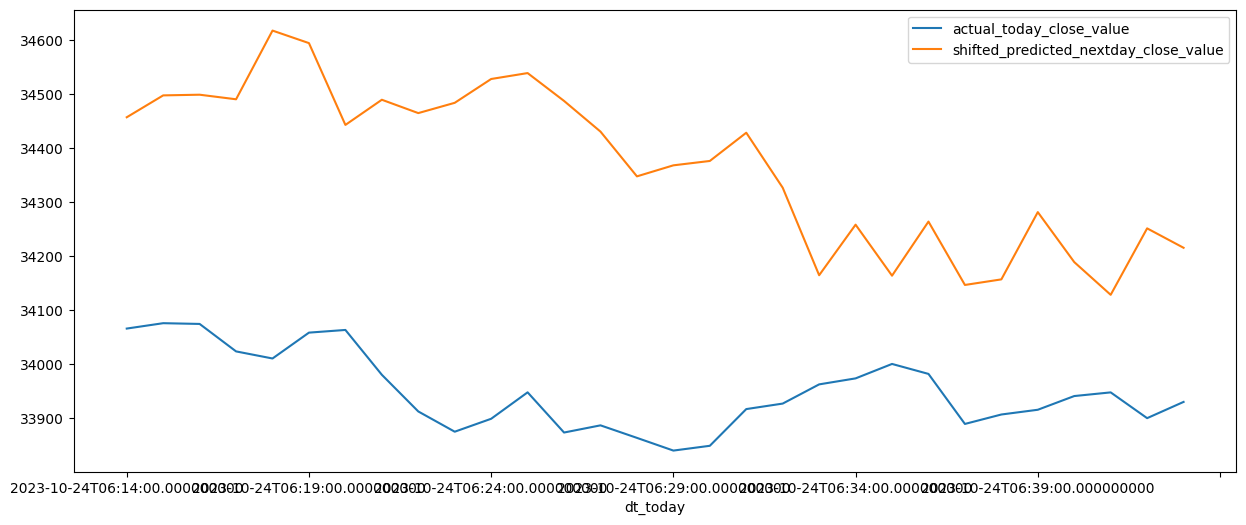

In [31]:
def show_model_result(model_results):
    # Creating the Numpy array
    array = np.array([
        np.array([str(dt) for dt in model_results["dt_today"]]), 
        model_results["actual_today_close_value"], 
        model_results["actual_nextday_close_value"], 
        model_results["predicted_nextday_close_value"]
    ]).transpose()
    
    # Creating a list of column names
    column_values = ["dt_today", 
                     "actual_today_close_value", 
                     "actual_nextday_close_value", 
                     "predicted_nextday_close_value"]
    # creating the dataframe
    df = pd.DataFrame(data=array, columns=column_values)
    
    shifted_pred = df["predicted_nextday_close_value"].shift(predicting_days)
    df["shifted_predicted_nextday_close_value"] = shifted_pred
    
    df = df.set_index("dt_today")
    
    df = df.where(pd.notna(df), np.nan).fillna(0.0)
    
    convert_dict = {'actual_today_close_value': float,
                    'actual_nextday_close_value': float,
                    'predicted_nextday_close_value': float,
                    'shifted_predicted_nextday_close_value': float}
    df = df.astype(convert_dict)
    
    
    df[["actual_today_close_value", "shifted_predicted_nextday_close_value"]].iloc[-30:].plot(figsize=(15, 6))
    
    
    df["actual_today_close_value"] = model_results["actual_today_close_value"]
    df = df.drop(["predicted_nextday_close_value"], axis=1)
    df["real_up"] = np.where(df["actual_today_close_value"] < df["actual_nextday_close_value"], 1, 0)
    df["pred_up"] = np.where(df["actual_today_close_value"] < df["shifted_predicted_nextday_close_value"], 1, 0)
    
    tp = tn = fp = fn = 0
    for _dt in model_results["dt_today"]:
        dt = str(_dt)
        # 1: up, 0: down
        if df.loc[dt, "real_up"] == 1 and df.loc[dt, "pred_up"] == 1:
            tp += 1
        elif df.loc[dt, "real_up"] == 0 and df.loc[dt, "pred_up"] == 0:
            tn += 1
        elif df.loc[dt, "real_up"] == 1 and df.loc[dt, "pred_up"] == 0:
            fn += 1
        elif df.loc[dt, "real_up"] == 0 and df.loc[dt, "pred_up"] == 1:
            fp += 1
            
    e = 0.000001
    
    acc = round(((tp + tn) / (tp + tn + fn + fp + e)), 4)
    recall = round(((tp) / (tp + fn + e)), 4)
    precision = round(((tp) / (tp + fp + e)), 4)
    f1 = round((2 * recall * precision) / (recall + precision + e), 4)
    
    print("accuracy:", acc)
    print("recall:", recall)
    print("precision:", precision)
    print("f1:", f1)
    
    print("avg_mae:", model_results["avg_mae"])
    print("avg_mse:", model_results["avg_mse"])
    print("avg_rmse:", model_results["avg_rmse"])
    
    return df

# show result for LinearRegression
res_df = show_model_result(all_model_results['sktime_LGBMRegressor'])

In [26]:
res_df

,actual_today_close_value,actual_nextday_close_value,shifted_predicted_nextday_close_value,real_up,pred_up
dt_today,,,,,
2023-10-23T22:24:00.000000000,31940.07,31924.60,0.000000,0,0
2023-10-23T22:25:00.000000000,31924.60,31941.04,31446.328654,1,0
2023-10-23T22:26:00.000000000,31941.04,31949.38,31446.328654,1,0
2023-10-23T22:27:00.000000000,31949.38,31998.88,31446.328654,1,0
2023-10-23T22:28:00.000000000,31998.88,32148.56,31446.328654,1,0
...,...,...,...,...,...
2023-10-24T06:39:00.000000000,33914.84,33940.25,34242.884037,1,1
2023-10-24T06:40:00.000000000,33940.25,33947.04,34242.884037,1,1
2023-10-24T06:41:00.000000000,33947.04,33899.28,34242.884037,0,1
